In [3]:
import json
import os
import shapely.geometry
from shapely.ops import transform
import pyproj
import rioxarray as rxr
import geopandas as gpd
import numpy as np
import xarray as xr
import glob
import osmnx as ox
import rasterio
from rasterio.features import rasterize

# Creating AOIs

In [1]:
import json
import os
import shapely.geometry
from shapely.ops import transform
import pyproj

# Make folder if it doesn't exist
folder = "aois_json"
os.makedirs(folder, exist_ok=True)

# City centers: (lon, lat)
cities = {
    "Vienna": (16.3738, 48.2082),
    "Paris": (2.3522, 48.8566),
    "London": (-0.1276, 51.5074),
    "Toronto": (-79.3832, 43.6532),
    "Vancouver": (-123.1207, 49.2827),
    "San Francisco": (-122.4194, 37.7749),
    "Lisbon": (-9.1393, 38.7223),
    "Madrid": (-3.7038, 40.4168),
    "Barcelona": (2.1734, 41.3851),
    "Berlin": (13.4050, 52.5200),
    "Amsterdam": (4.9041, 52.3676),
    "Melbourne": (144.9631, -37.8136),
    "Sydney": (151.2093, -33.8688),
    "Auckland": (174.7633, -36.8485),
    "Seattle": (-122.3321, 47.6062)
}

# AOI size in meters (~5.12 km to match 512x512 pixels at 10 m)
size_m = 512 * 10  

def create_square_aoi(center_lon, center_lat, size_m):
    """
    Create a square AOI of size_m x size_m around the city center.
    """
    utm_zone = int((center_lon + 180) / 6) + 1
    utm = pyproj.Proj(proj='utm', zone=utm_zone, ellps='WGS84')
    wgs84 = pyproj.Proj(proj='latlong', datum='WGS84')

    project_to_utm = pyproj.Transformer.from_proj(wgs84, utm, always_xy=True).transform
    project_to_wgs = pyproj.Transformer.from_proj(utm, wgs84, always_xy=True).transform

    point = shapely.geometry.Point(center_lon, center_lat)
    point_utm = transform(project_to_utm, point)

    half_size = size_m / 2
    square_utm = shapely.geometry.box(
        point_utm.x - half_size,
        point_utm.y - half_size,
        point_utm.x + half_size,
        point_utm.y + half_size
    )

    square_wgs = transform(project_to_wgs, square_utm)
    return square_wgs

# Generate one JSON per city
for city, (lon, lat) in cities.items():
    square = create_square_aoi(lon, lat, size_m)
    polygon_coords = [list(coord) for coord in square.exterior.coords]
    geojson = {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "properties": {"city": city},
                "geometry": {"type": "Polygon", "coordinates": [polygon_coords]}
            }
        ]
    }
    filepath = os.path.join(folder, f"{city.replace(' ', '_')}.geojson")
    with open(filepath, "w") as f:
        json.dump(geojson, f, indent=2)
    print(f"Saved {filepath}")

print("All 15 city AOIs saved as separate GeoJSON files in 'aois_json' folder.")

Saved aois_json/Vienna.geojson
Saved aois_json/Paris.geojson
Saved aois_json/London.geojson
Saved aois_json/Toronto.geojson
Saved aois_json/Vancouver.geojson
Saved aois_json/San_Francisco.geojson
Saved aois_json/Lisbon.geojson
Saved aois_json/Madrid.geojson
Saved aois_json/Barcelona.geojson
Saved aois_json/Berlin.geojson
Saved aois_json/Amsterdam.geojson
Saved aois_json/Melbourne.geojson
Saved aois_json/Sydney.geojson
Saved aois_json/Auckland.geojson
Saved aois_json/Seattle.geojson
All 15 city AOIs saved as separate GeoJSON files in 'aois_json' folder.


# Creating MultiMonth Stacks from Sentinel

In [1]:
import rioxarray as rxr
import geopandas as gpd
import numpy as np
import xarray as xr
import os
import glob

# ------------------------------
# Paths and Configuration
# ------------------------------
aoi_base_folder = "aois_json"
sentinel_base_folder = "sentinel_data"

# Define cities and months
cities = ["Amsterdam", "Auckland", "Barcelona", "Berlin", "Kyiv"]
months = ["April", "August", "November"]
band_substrings = ["B02", "B03", "B04", "B08"]

# ------------------------------
# Process each city
# ------------------------------
for city in cities:
    print(f"\n{'='*60}")
    print(f"PROCESSING CITY: {city}")
    print(f"{'='*60}")
    
    # Define paths for this city
    aoi_file = os.path.join(aoi_base_folder, f"{city}.geojson")
    output_file = os.path.join(sentinel_base_folder, city, f"{city}_MultiMonth_stack.tif")
    
    # Check if AOI file exists
    if not os.path.exists(aoi_file):
        print(f"WARNING: AOI file not found for {city}: {aoi_file}")
        print(f"Skipping {city}...")
        continue
    
    # ------------------------------
    # Load AOI and extract geometries
    # ------------------------------
    aoi = gpd.read_file(aoi_file)
    
    # Merge multiple features if needed
    if len(aoi) > 1:
        merged_geom = aoi.unary_union
        geometries = [merged_geom]
    else:
        geometries = [aoi.geometry.iloc[0]]
    
    # Ensure geometries are in WGS84
    for i, g in enumerate(geometries):
        if aoi.crs is None:
            aoi.set_crs("EPSG:4326", inplace=True)
        if aoi.crs.to_epsg() != 4326:
            geometries[i] = g.to_crs("EPSG:4326")
    
    # ------------------------------
    # Process each month for this city
    # ------------------------------
    all_band_arrays = []
    all_band_names = []
    
    for month in months:
        folder_path = os.path.join(sentinel_base_folder, city, f"{city}-{month}-10m")
        print(f"\n=== Processing {city} - {month} ===")
        
        # Check if folder exists
        if not os.path.exists(folder_path):
            print(f"WARNING: Folder not found: {folder_path}")
            print(f"Skipping {month} for {city}...")
            continue
        
        month_band_dict = {}
        
        # Load and clip each band for this month
        for substring in band_substrings:
            matched_files = glob.glob(os.path.join(folder_path, f"*{substring}*"))
            if not matched_files:
                print(f"WARNING: No file found for band '{substring}' in {folder_path}")
                continue
            
            band_path = matched_files[0]
            band = rxr.open_rasterio(band_path, masked=True).squeeze()
            
            # Clip to AOI using plain list of shapely geometries
            band_clipped = band.rio.clip(geometries, crs="EPSG:4326")
            
            # Store with month-specific name
            band_name = f"{substring}-{month}"
            all_band_arrays.append(band_clipped)
            all_band_names.append(band_name)
            month_band_dict[substring] = band_clipped
            
            print(f"Loaded and clipped {band_name} -> shape: {band_clipped.shape}")
        
        # Only calculate indices if all required bands are present
        if len(month_band_dict) < 3:
            print(f"WARNING: Missing bands for {month}, skipping index calculations")
            continue
        
        # ------------------------------
        # Calculate NDVI for this month
        # ------------------------------
        if "B08" in month_band_dict and "B04" in month_band_dict:
            nir = month_band_dict["B08"].astype(np.float32)
            red = month_band_dict["B04"].astype(np.float32)
            
            ndvi = (nir - red) / (nir + red)
            ndvi = xr.where(np.isfinite(ndvi), ndvi, np.nan)
            ndvi_name = f"NDVI-{month}"
            all_band_arrays.append(ndvi)
            all_band_names.append(ndvi_name)
            print(f"Calculated {ndvi_name} -> range: [{float(ndvi.min()):.3f}, {float(ndvi.max()):.3f}]")
        
        # ------------------------------
        # Calculate EVI
        # ------------------------------
        if "B08" in month_band_dict and "B04" in month_band_dict and "B02" in month_band_dict:
            blue = month_band_dict["B02"].astype(np.float32)
            
            evi = 2.5 * (nir - red) / (nir + 6*red - 7.5*blue + 1)
            evi = xr.where(np.isfinite(evi), evi, np.nan)
            evi_name = f"EVI-{month}"
            all_band_arrays.append(evi)
            all_band_names.append(evi_name)
            print(f"Calculated {evi_name} -> range: [{float(evi.min()):.3f}, {float(evi.max()):.3f}]")
        
        # ------------------------------
        # Calculate SAVI
        # ------------------------------
        if "B08" in month_band_dict and "B04" in month_band_dict:
            L = 0.5
            savi = ((nir - red) * (1 + L)) / (nir + red + L)
            savi = xr.where(np.isfinite(savi), savi, np.nan)
            savi_name = f"SAVI-{month}"
            all_band_arrays.append(savi)
            all_band_names.append(savi_name)
            print(f"Calculated {savi_name} -> range: [{float(savi.min()):.3f}, {float(savi.max()):.3f}]")
    
    # ------------------------------
    # Stack all bands from all months for this city
    # ------------------------------
    if not all_band_arrays:
        print(f"\nWARNING: No bands processed for {city}, skipping stack creation")
        continue
    
    print(f"\n=== Creating final stack for {city} ===")
    stack = xr.concat(all_band_arrays, dim="band")
    stack = stack.assign_coords(band=all_band_names)
    
    # Convert entire stack to float32
    stack = stack.astype(np.float32)
    
    print(f"Stacked all bands > shape: {stack.shape}")
    print(f"Total bands: {len(all_band_names)}")
    
    # ------------------------------
    # Save as GeoTIFF
    # ------------------------------
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    stack.rio.to_raster(output_file, dtype=np.float32)
    print(f"\nSaved stacked GeoTIFF: {output_file}")
    print(f"Band order: {all_band_names}")

print(f"\n{'='*60}")
print("ALL CITIES PROCESSED!")
print(f"{'='*60}")

C:\Users\Michał\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



PROCESSING CITY: Amsterdam

=== Processing Amsterdam - April ===
Loaded and clipped B02-April -> shape: (512, 512)
Loaded and clipped B03-April -> shape: (512, 512)
Loaded and clipped B04-April -> shape: (512, 512)
Loaded and clipped B08-April -> shape: (512, 512)
Calculated NDVI-April -> range: [-0.515, 0.688]
Calculated EVI-April -> range: [-3915.000, 4470.000]
Calculated SAVI-April -> range: [-0.772, 1.032]

=== Processing Amsterdam - August ===
Loaded and clipped B02-August -> shape: (512, 512)
Loaded and clipped B03-August -> shape: (512, 512)
Loaded and clipped B04-August -> shape: (512, 512)
Loaded and clipped B08-August -> shape: (512, 512)
Calculated NDVI-August -> range: [-0.245, 0.849]
Calculated EVI-August -> range: [-4035.000, 7515.000]
Calculated SAVI-August -> range: [-0.367, 1.273]

=== Processing Amsterdam - November ===
Loaded and clipped B02-November -> shape: (512, 512)
Loaded and clipped B03-November -> shape: (512, 512)
Loaded and clipped B04-November -> shape: (

# Creating raster pictures from OSM data

In [2]:
import osmnx as ox
import geopandas as gpd
import os

# ------------------------------
# Configuration
# ------------------------------
aoi_base_folder = "aois_json"
output_base_folder = "sentinel_data"
cities = ["Amsterdam", "Auckland", "Barcelona", "Berlin", "Kyiv"]

# Define tags for green areas
tags = {
    "leisure": ["park", "garden"],
    "landuse": ["forest", "grass", "meadow", "village_green"],
    "natural": ["wood", "scrub"]
}

# ------------------------------
# Process each city
# ------------------------------
for city in cities:
    print(f"\n{'='*60}")
    print(f"PROCESSING: {city}")
    print(f"{'='*60}")
    
    # Define paths
    aoi_file = os.path.join(aoi_base_folder, f"{city}.geojson")
    output_file = os.path.join(output_base_folder, city, f"{city}_OSM_green.geojson")
    
    # Check if AOI file exists
    if not os.path.exists(aoi_file):
        print(f"WARNING: AOI file not found: {aoi_file}")
        print(f"Skipping {city}...")
        continue
    
    try:
        # Load AOI
        aoi = gpd.read_file(aoi_file)
        aoi = aoi.to_crs("EPSG:4326")  # ensure WGS84
        polygon = aoi.geometry.iloc[0]  # get shapely polygon
        
        print(f"Loaded AOI for {city}")
        
        # Fetch green features from OSM
        print(f"Fetching OSM green areas...")
        green_features = ox.features_from_polygon(polygon, tags)
        
        # Keep only polygons
        green_features = green_features[green_features.geometry.type.isin(["Polygon", "MultiPolygon"])]
        
        if len(green_features) == 0:
            print(f"WARNING: No green area polygons found for {city}")
            continue
        
        # Calculate total area
        total_area_km2 = green_features.to_crs('EPSG:3857').area.sum() / 1e6
        
        # Save to GeoJSON
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        green_features.to_file(output_file, driver="GeoJSON")
        
        print(f"✓ Saved: {output_file}")
        print(f"  Features: {len(green_features)}")
        print(f"  Total area: {total_area_km2:.2f} km²")
        
    except Exception as e:
        print(f"ERROR processing {city}: {str(e)}")
        continue

print(f"\n{'='*60}")
print("ALL CITIES PROCESSED!")
print(f"{'='*60}")


PROCESSING: Amsterdam
Loaded AOI for Amsterdam
Fetching OSM green areas...
✓ Saved: sentinel_data\Amsterdam\Amsterdam_OSM_green.geojson
  Features: 4396
  Total area: 16.04 km²

PROCESSING: Auckland
Loaded AOI for Auckland
Fetching OSM green areas...
✓ Saved: sentinel_data\Auckland\Auckland_OSM_green.geojson
  Features: 1615
  Total area: 5.75 km²

PROCESSING: Barcelona
Loaded AOI for Barcelona
Fetching OSM green areas...
✓ Saved: sentinel_data\Barcelona\Barcelona_OSM_green.geojson
  Features: 1915
  Total area: 6.38 km²

PROCESSING: Berlin
Loaded AOI for Berlin
Fetching OSM green areas...
✓ Saved: sentinel_data\Berlin\Berlin_OSM_green.geojson
  Features: 3371
  Total area: 20.91 km²

PROCESSING: Kyiv
Loaded AOI for Kyiv
Fetching OSM green areas...
✓ Saved: sentinel_data\Kyiv\Kyiv_OSM_green.geojson
  Features: 1471
  Total area: 24.64 km²

ALL CITIES PROCESSED!


In [6]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np
import os

# ------------------------------
# Configuration
# ------------------------------
sentinel_base_folder = "sentinel_data"
cities = ["Amsterdam", "Auckland", "Barcelona", "Berlin", "Kyiv"]

# ------------------------------
# Process each city
# ------------------------------
for city in cities:
    print(f"\n{'='*60}")
    print(f"PROCESSING: {city}")
    print(f"{'='*60}")
    
    # Define paths
    stack_path = os.path.join(sentinel_base_folder, city, f"{city}_MultiMonth_stack.tif")
    osm_path = os.path.join(sentinel_base_folder, city, f"{city}_OSM_green.geojson")
    label_path = os.path.join(sentinel_base_folder, city, f"{city}_OSM_labels.tif")
    
    # Check if required files exist
    if not os.path.exists(stack_path):
        print(f"WARNING: Stack file not found: {stack_path}")
        print(f"Skipping {city}...")
        continue
    
    if not os.path.exists(osm_path):
        print(f"WARNING: OSM green file not found: {osm_path}")
        print(f"Skipping {city}...")
        continue
    
    try:
        # Load Sentinel-2 stack metadata
        with rasterio.open(stack_path) as src:
            transform = src.transform
            out_shape = (src.height, src.width)
            crs = src.crs
        
        print(f"Loaded stack metadata: {out_shape[0]}x{out_shape[1]} pixels")
        
        # Load GeoJSON of green areas from OSM
        green_features = gpd.read_file(osm_path)
        
        # Ensure CRS matches Sentinel-2
        green_features = green_features.to_crs(crs)
        
        # Keep only polygons
        green_features = green_features[green_features.geometry.type.isin(["Polygon", "MultiPolygon"])]
        
        if len(green_features) == 0:
            print(f"WARNING: No polygon features found for {city}")
            continue
        
        print(f"Loaded {len(green_features)} green area polygons")
        
        # ------------------------------
        # Rasterize with all_touched approach
        # ------------------------------
        print("Rasterizing green areas...")
        
        labels = rasterize(
            [(geom, 1) for geom in green_features.geometry],
            out_shape=out_shape,
            transform=transform,
            fill=0,
            all_touched=True,   # include pixels partially covered
            dtype="uint8"
        )
        
        green_count = np.sum(labels == 1)
        total_pixels = labels.size
        print(f"  Completed: {green_count}/{total_pixels} pixels labeled as green ({100*green_count/total_pixels:.2f}%)")
        
        # ------------------------------
        # Save raster labels
        # ------------------------------
        with rasterio.open(
            label_path,
            "w",
            driver="GTiff",
            height=out_shape[0],
            width=out_shape[1],
            count=1,
            dtype="uint8",
            crs=crs,
            transform=transform,
            compress="lzw"  # Add compression to reduce file size
        ) as dst:
            dst.write(labels, 1)
        
        print(f"✓ Saved: {label_path}")
        
    except Exception as e:
        print(f"ERROR processing {city}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*60}")
print("ALL CITIES PROCESSED!")
print(f"{'='*60}")


PROCESSING: Amsterdam
Loaded stack metadata: 512x512 pixels
Loaded 4396 green area polygons
Rasterizing green areas...
  Completed: 61456/262144 pixels labeled as green (23.44%)
✓ Saved: sentinel_data\Amsterdam\Amsterdam_OSM_labels.tif

PROCESSING: Auckland
Loaded stack metadata: 512x512 pixels
Loaded 1615 green area polygons
Rasterizing green areas...
  Completed: 37236/262144 pixels labeled as green (14.20%)
✓ Saved: sentinel_data\Auckland\Auckland_OSM_labels.tif

PROCESSING: Barcelona
Loaded stack metadata: 512x512 pixels
Loaded 1915 green area polygons
Rasterizing green areas...
  Completed: 34806/262144 pixels labeled as green (13.28%)
✓ Saved: sentinel_data\Barcelona\Barcelona_OSM_labels.tif

PROCESSING: Berlin
Loaded stack metadata: 1066x1065 pixels
Loaded 3371 green area polygons
Rasterizing green areas...
  Completed: 5087/1135290 pixels labeled as green (0.45%)
✓ Saved: sentinel_data\Berlin\Berlin_OSM_labels.tif

PROCESSING: Kyiv
Loaded stack metadata: 552x552 pixels
Loaded 

# Class imbalance

In [4]:
import rasterio
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load Sentinel-2 stack
with rasterio.open("sentinel_data/Amsterdam/Amsterdam_MultiMonth_stack.tif") as src:
    X = src.read()  # shape: (bands, height, width)

# Load labels
with rasterio.open("sentinel_data/Amsterdam/Amsterdam_OSM_labels.tif") as src:
    y = src.read(1)  # shape: (height, width)

# Flatten to (n_samples, n_features)
n_bands, h, w = X.shape
X_flat = X.reshape(n_bands, -1).T  # shape: (h*w, n_bands)
y_flat = y.flatten()                # shape: (h*w,)

# Remove NaN values
mask = ~np.isnan(X_flat).any(axis=1)
X_flat = X_flat[mask]
y_flat = y_flat[mask]

# ------------------------------
# Check class distribution
# ------------------------------
unique, counts = np.unique(y_flat, return_counts=True)
total = len(y_flat)
print("="*60)
print("CLASS DISTRIBUTION:")
print("="*60)
for label, count in zip(unique, counts):
    print(f"Class {label}: {count:,} samples ({100*count/total:.2f}%)")
print(f"\nImbalance ratio: {counts[0]/counts[1]:.1f}:1 (non-green:green)")
print("="*60)

# ------------------------------
# Split with stratification
# ------------------------------
# Stratify ensures both train and test have similar class distributions
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_flat, 
    test_size=0.2, 
    random_state=42,
    stratify=y_flat  # Important for imbalanced data!
)

print(f"\nTrain set: {len(y_train):,} samples")
print(f"  Green: {np.sum(y_train==1):,} ({100*np.mean(y_train==1):.2f}%)")
print(f"Test set: {len(y_test):,} samples")
print(f"  Green: {np.sum(y_test==1):,} ({100*np.mean(y_test==1):.2f}%)")

CLASS DISTRIBUTION:
Class 0: 200,557 samples (76.55%)
Class 1: 61,443 samples (23.45%)

Imbalance ratio: 3.3:1 (non-green:green)

Train set: 209,600 samples
  Green: 49,154 (23.45%)
Test set: 52,400 samples
  Green: 12,289 (23.45%)


#  Random Forest - Amsterdam

In [ ]:
# ------------------------------
# Train Random Forest
# ------------------------------
print("\n" + "="*60)
print("TRAINING RANDOM FOREST...")
print("="*60)

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    min_samples_split=10,      # Prevent overfitting on minority class
    min_samples_leaf=5,        # Ensure leaves have enough samples
    class_weight="balanced",   # Handle imbalance
    n_jobs=-1,
    random_state=42,
    verbose=1
)
clf.fit(X_train, y_train)

# ------------------------------
# Evaluate with multiple metrics
# ------------------------------
y_pred = clf.predict(X_test)

print("\n" + "="*60)
print("EVALUATION METRICS:")
print("="*60)

# Classification report (precision, recall, F1 for each class)
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-green", "Green"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print("                Predicted")
print("              Non-green  Green")
print(f"Actual Non-g  {cm[0,0]:8d}  {cm[0,1]:6d}")
print(f"       Green  {cm[1,0]:8d}  {cm[1,1]:6d}")

# Additional metrics for imbalanced data
print("\n" + "-"*60)
print("IMBALANCED DATA METRICS:")
print("-"*60)
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score (Green):  {f1_score(y_test, y_pred, pos_label=1):.3f}")
print(f"F1 Score (Macro):  {f1_score(y_test, y_pred, average='macro'):.3f}")

# Calculate specificity and sensitivity manually
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall for green class
specificity = tn / (tn + fp)  # Recall for non-green class
print(f"Sensitivity (Green Recall):     {sensitivity:.3f}")
print(f"Specificity (Non-green Recall): {specificity:.3f}")

# ------------------------------
# Feature importance
# ------------------------------
print("\n" + "="*60)
print("BAND IMPORTANCE:")
print("="*60)

# Get band names (you can customize this based on your actual bands)
band_names = [f"Band_{i+1}" for i in range(n_bands)]

# Sort by importance
importance_idx = np.argsort(clf.feature_importances_)[::-1]
for idx in importance_idx[:10]:  # Top 10
    print(f"{band_names[idx]:15s}: {clf.feature_importances_[idx]:.4f}")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)

CLASS DISTRIBUTION:
Class 0: 200,557 samples (76.55%)
Class 1: 61,443 samples (23.45%)

Imbalance ratio: 3.3:1 (non-green:green)

Train set: 209,600 samples
  Green: 49,154 (23.45%)
Test set: 52,400 samples
  Green: 12,289 (23.45%)

TRAINING RANDOM FOREST...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   17.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.2s finished



EVALUATION METRICS:

Detailed Classification Report:
              precision    recall  f1-score   support

   Non-green       0.90      0.89      0.90     40111
       Green       0.66      0.69      0.67     12289

    accuracy                           0.84     52400
   macro avg       0.78      0.79      0.78     52400
weighted avg       0.84      0.84      0.84     52400


Confusion Matrix:
                Predicted
              Non-green  Green
Actual Non-g     35706    4405
       Green      3868    8421

------------------------------------------------------------
IMBALANCED DATA METRICS:
------------------------------------------------------------
Balanced Accuracy: 0.788
F1 Score (Green):  0.671
F1 Score (Macro):  0.783
Sensitivity (Green Recall):     0.685
Specificity (Non-green Recall): 0.890

BAND IMPORTANCE:
Band_5         : 0.1620
Band_7         : 0.1472
Band_14        : 0.0901
Band_4         : 0.0765
Band_12        : 0.0591
Band_11        : 0.0533
Band_21        : 0.0


Classification report (on labeled pixels):
              precision    recall  f1-score   support

   Non-green       0.90      0.89      0.90     40111
       Green       0.66      0.69      0.67     12289

    accuracy                           0.84     52400
   macro avg       0.78      0.79      0.78     52400
weighted avg       0.84      0.84      0.84     52400

Confusion matrix:
 [[35706  4405]
 [ 3868  8421]]
Balanced accuracy: 0.7877133600121815
F1 (green): 0.6705952617957396


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.8s finished


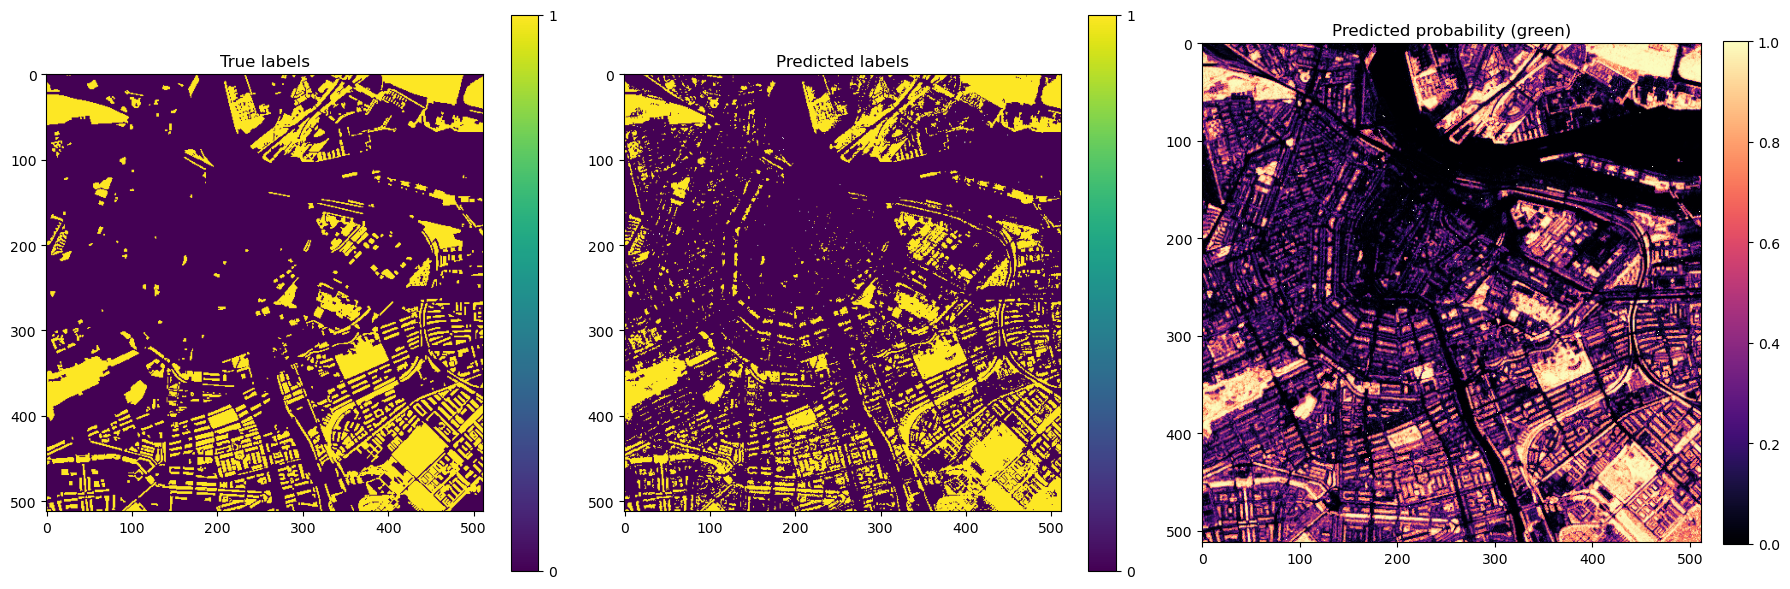

In [10]:
import matplotlib.pyplot as plt

# -----------------------------
# Metrics on labeled pixels
# -----------------------------
y_true = y_test  # already defined earlier

print("\nClassification report (on labeled pixels):")
print(classification_report(y_true, y_pred, target_names=["Non-green", "Green"]))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

print("Balanced accuracy:", balanced_accuracy_score(y_true, y_pred))
print("F1 (green):", f1_score(y_true, y_pred, pos_label=1))

# -----------------------------
# Create full prediction maps
# -----------------------------
# Predict on all valid pixels
y_full_pred = clf.predict(X_flat)
y_full_prob = clf.predict_proba(X_flat)[:, 1]

# Initialize empty maps
pred_map = np.full(h * w, np.nan)
prob_map = np.full(h * w, np.nan)

# Insert predictions back using mask
pred_map[mask] = y_full_pred
prob_map[mask] = y_full_prob

# Reshape to image form
pred_map = pred_map.reshape(h, w)
prob_map = prob_map.reshape(h, w)

# -----------------------------
# Visualization (matplotlib)
# -----------------------------
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("True labels")
plt.imshow(y, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(ticks=[0, 1])

plt.subplot(1, 3, 2)
plt.title("Predicted labels")
plt.imshow(pred_map, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(ticks=[0, 1])

plt.subplot(1, 3, 3)
plt.title("Predicted probability (green)")
im = plt.imshow(prob_map, cmap='magma', vmin=0, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


# SVM - Amsterdam

In [5]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

print("\n" + "="*60)
print("TRAINING SUPPORT VECTOR MACHINE...")
print("="*60)

# --------------------------------
# Fixed SVM pipeline (no tuning)
# --------------------------------
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=10.0,                 # reasonable default for Sentinel-2
        gamma="scale",          # stable and data-adaptive
        class_weight="balanced",
        probability=True,       # needed for prob_map
        random_state=42
    ))
])

# Train
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]


TRAINING SUPPORT VECTOR MACHINE...



Classification report (on labeled pixels):
              precision    recall  f1-score   support

   Non-green       0.93      0.81      0.87     40111
       Green       0.56      0.80      0.66     12289

    accuracy                           0.81     52400
   macro avg       0.75      0.80      0.76     52400
weighted avg       0.84      0.81      0.82     52400

Confusion matrix:
 [[32447  7664]
 [ 2452  9837]]
Balanced accuracy: 0.8047010927214209
F1 (green): 0.6604229607250756


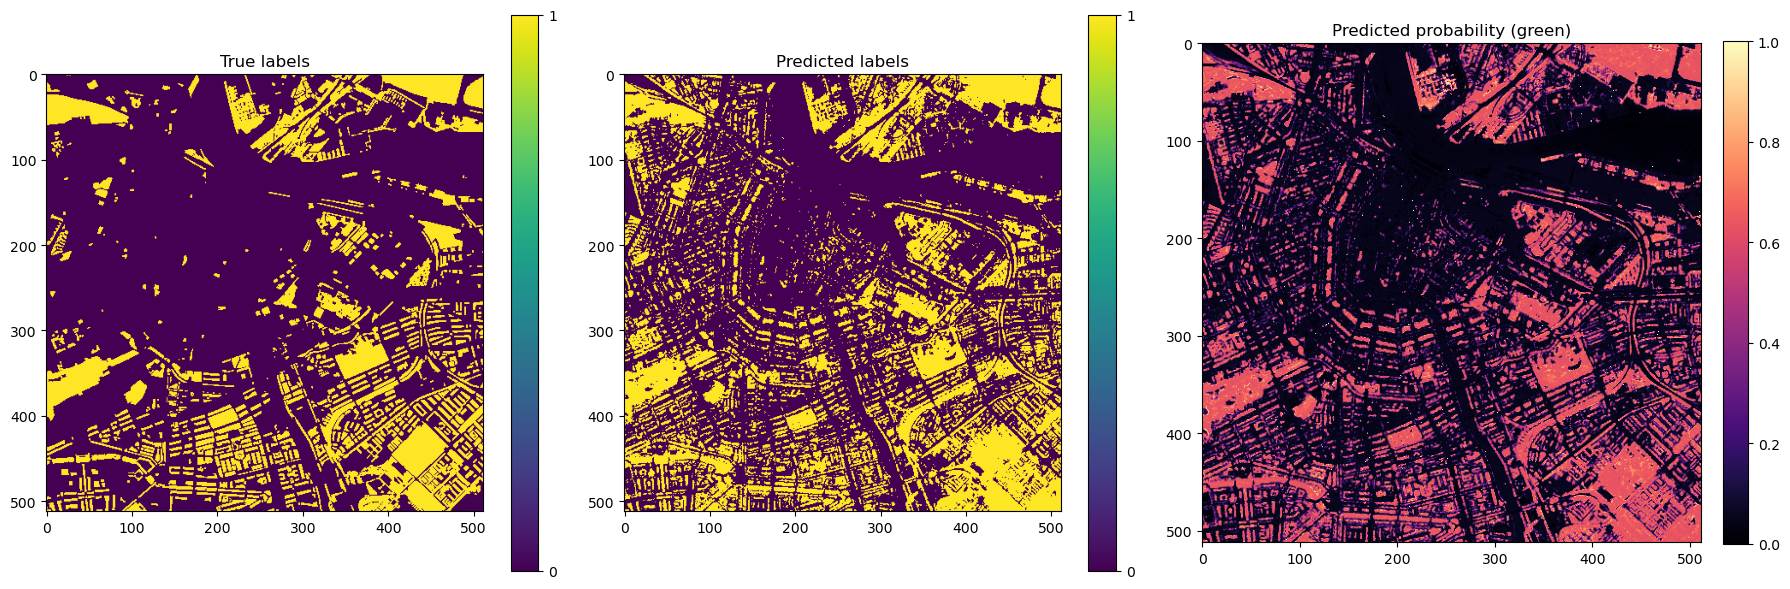

In [6]:
import matplotlib.pyplot as plt

# -----------------------------
# Metrics on labeled pixels
# -----------------------------
y_true = y_test  # already defined earlier

print("\nClassification report (on labeled pixels):")
print(classification_report(y_true, y_pred, target_names=["Non-green", "Green"]))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

print("Balanced accuracy:", balanced_accuracy_score(y_true, y_pred))
print("F1 (green):", f1_score(y_true, y_pred, pos_label=1))

# -----------------------------
# Create full prediction maps
# -----------------------------
# Predict on all valid pixels
y_full_pred = clf.predict(X_flat)
y_full_prob = clf.predict_proba(X_flat)[:, 1]

# Initialize empty maps
pred_map = np.full(h * w, np.nan)
prob_map = np.full(h * w, np.nan)

# Insert predictions back using mask
pred_map[mask] = y_full_pred
prob_map[mask] = y_full_prob

# Reshape to image form
pred_map = pred_map.reshape(h, w)
prob_map = prob_map.reshape(h, w)

# -----------------------------
# Visualization (matplotlib)
# -----------------------------
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("True labels")
plt.imshow(y, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(ticks=[0, 1])

plt.subplot(1, 3, 2)
plt.title("Predicted labels")
plt.imshow(pred_map, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(ticks=[0, 1])

plt.subplot(1, 3, 3)
plt.title("Predicted probability (green)")
im = plt.imshow(prob_map, cmap='magma', vmin=0, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
